In [1]:
import os

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
import numpy as np
from utils import clean_sentences, show_history_graph
from trainer import Trainer

try:
  import google.colab
  IN_COLAB = True
  drive.mount('/content/drive')
except:
  IN_COLAB = False


In [2]:
if IN_COLAB:
    imdb_path = "/content/drive/MyDrive/Colab Notebooks/dataset/imdb_simple/IMDB Dataset.csv"
else:
    imdb_path = "dataset/IMDB Dataset.csv"

imdb_df = pd.read_csv(imdb_path)
print(len(imdb_df))

imdb_df['sentiment'].value_counts()
imdb_sentiment = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})
print(imdb_sentiment.value_counts())

x = imdb_df['review'].to_numpy()
y = imdb_sentiment.to_numpy()
print(len(x), len(y))
print(x.shape, y.shape)
print(x[0])
print(y[0])

50000
sentiment
1    25000
0    25000
Name: count, dtype: int64
50000 50000
(50000,) (50000,)
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agree

In [3]:
# clean sentences
x = [clean_sentences(entry) for entry in x]

In [4]:
from tokenizers import Tokenizer, decoders, models, normalizers, pre_tokenizers, trainers, processors
tokenizer = Tokenizer(models.WordPiece())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer.post_processor = processors.BertProcessing(sep=('[SEP]', 2), cls=('[CLS]', 3))
tokenizer.decoder = decoders.WordPiece()
token_trainer = trainers.WordPieceTrainer(
    vocab_size = 10000,
    special_tokens=["[PAD]", "[UNK]", "[SEP]", "[CLS]"],
    show_progress=True,
)

tokenizer.train_from_iterator(x, trainer=token_trainer)
max_len = 200
tokenizer.enable_truncation(max_len)
tokenizer.enable_padding(length=max_len)


print(x[0])
temp = tokenizer.encode(x[0]) 
print(temp.tokens)
print(temp.ids)
print(tokenizer.decode(temp.ids))




One of the other reviewers has mentioned that after watching just 1 Oz episode you ' ll be hooked .  They are right ,  as this is exactly what happened with me . The first thing that struck me about Oz was its brutality and unflinching scenes of violence ,  which set in right from the word GO .  Trust me ,  this is not a show for the faint hearted or timid .  This show pulls no punches with regards to drugs ,  sex or violence .  Its is hardcore ,  in the classic use of the word . It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary .  It focuses mainly on Emerald City ,  an experimental section of the prison where all the cells have glass fronts and face inwards ,  so privacy is not high on the agenda .  Em City is home to many .  . Aryans ,  Muslims ,  gangstas ,  Latinos ,  Christians ,  Italians ,  Irish and more .  .  .  . so scuffles ,  death stares ,  dodgy dealings and shady agreements are never far away . I would say the main appeal 

In [5]:
x_word_piece_token_list = np.array([tokenizer.encode(entry).ids for entry in x])
print(x_word_piece_token_list.shape)   
print(x_word_piece_token_list[0])     

(50000, 200)
[   3 1240  328  313  606 5072  485 3039  353  729  855  482   22 6488
 1604  391   12 1124  345 7091   19  999  406  972   17  377  359  334
 2138  528 2054  382  486   19  375  660  659  353 7177  486  484 6488
  369  685 4391  529  326 1571 2399 5837  791  328 2035   17  546  872
  333  972  465  313 1451 7185   19 7362  350  486   17  359  334  368
   70  558  372  313 2067  636 5260  463  498  373   19  505  558 6023
  539 4269  317  382 3219  206  329 3940   17 1018  463 2035   19 2539
  334 8554   17  333  313 1506 1363  328  313 1451   19  459  334 1653
   52  237  377  353  334  313   83  570 4764  200 1516  329  313   52
 2553 2255 4599  371  473 3235 4985 9066 1977 9792 1174 4233  629   19
  459 6209 3879  352 2840 4152  196 3380   17  384 9878 5809  328  313
 2747  743  439  313 3921  206  413 5268 2588  206  326 1579  333 2100
   17  434 4451 2783  334  368  947  352  313 2009 6644   19 2840 3380
  334 1393  329  733   19   19 1355 6643 8876   17 8997  206   1

In [6]:
batch_size = 256

x_tensors = torch.tensor(x_word_piece_token_list)
y_tensors = torch.tensor(y)
wp_dataset = TensorDataset(x_tensors, y_tensors)

train_wp_dataset, val_wp_dataset, test_wp_dataset = random_split(wp_dataset, lengths=[0.7, 0.15, 0.15])
train_wp_dataloder = DataLoader(train_wp_dataset, batch_size=batch_size, shuffle=True)
val_wp_dataloader = DataLoader(val_wp_dataset, batch_size=batch_size, shuffle=False)
test_wp_dataloader = DataLoader(test_wp_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class TorchLSTM(nn.Module):
    def __init__(self, config, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.config = config
        self.embedding = nn.Embedding(
            num_embeddings=config['vocab_size'], 
            embedding_dim=config['embedding_dim']
            )
        self.lstm = nn.LSTM(
            input_size=config['embedding_dim'], 
            hidden_size=config['hidden_size'], 
            num_layers=config['num_layers'], 
            bidirectional=True,
            batch_first=True, 
            dropout=config['dropout']
        )
        self.fnn = nn.Linear(
            in_features=config['hidden_size'] * 2, 
            out_features=1
            )
        
    def forward(self, x):
        out = self.embedding(x)
        output, _ = self.lstm(out)
        # output ( batch, seq_len, input_size)
        last_output = output[:, -1, :].squeeze()
        # last_output = (batch, input_size)
        out = self.fnn(last_output)
        return out

start training : lr=0.001


 16%|█▌        | 16/100 [00:40<03:34,  2.56s/it, train_loss=0.21162, val_loss=0.46321, train_accu=0.92 val_accu=0.83]

Early stopping at epoch 16
output/TorchLSTM_ep_11_loss_0.3909.pt


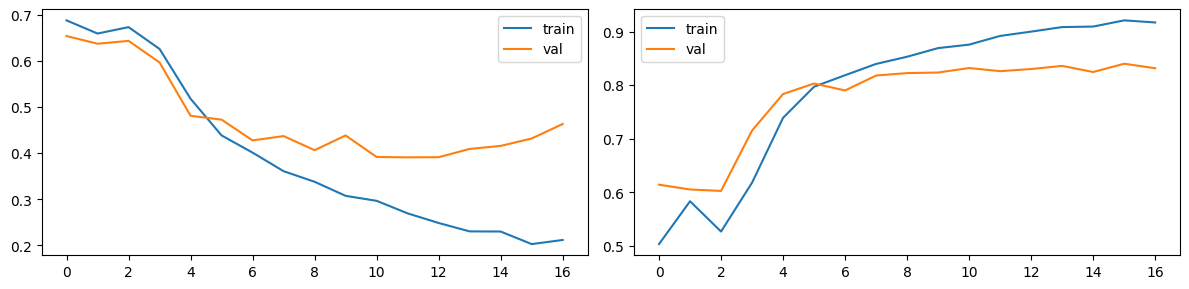

In [10]:
config = {}

config['vocab_size'] = tokenizer.get_vocab_size()
config['device'] = 'cuda' if torch.cuda.is_available() else "cpu"
config['epoch'] = 100
config['learning_rate'] = 1e-3
config['embedding_dim'] = 256
config['hidden_size'] = 64
config['num_layers'] = 3
config['dropout'] = 0.4
config['batch_size'] = batch_size

model = TorchLSTM(config)
trainer = Trainer(config, model, train_wp_dataloder, val_wp_dataloader)
history, last_ckpt_path = trainer.train()
show_history_graph(history)